<a href="https://colab.research.google.com/github/JoanComputing/CIBR/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final:  Content Based Image Retrieval (CBIR)

## Integrantes: Juan Vergara y Roberto Zuñiga


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import feature
import csv
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Proyecto

Mounted at /content/drive
/content/drive/MyDrive/Proyecto


## Funcion que extrae vector de caracteristicas :

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="The default value of the antialias parameter.*")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()
def feature_extractor(img:str, metodo:str, model=None)->np.ndarray:
    """
    Funcion que extrae las caracteristicas de una imagen
    y las devuelve en un vector de numpy
    """
    if metodo == "hog":
        img = cv2.imread(img)
        img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
        features = feature.hog(img, orientations=9,
                    pixels_per_cell=(32, 32), cells_per_block=(12, 12),channel_axis=-1,block_norm='L2-Hys')
        return features
    elif metodo == "CNN":
        image = Image.open(img)
        transform = transforms.Compose([
            transforms.Resize((512, 512),antialias=True),
            transforms.ToTensor(),models.ResNet18_Weights.DEFAULT.transforms()
        ])
        image = transform(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            caract = model(image)

        return caract.squeeze()
    else:
        print("Metodo no valido")
        return None

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.0MB/s]


## Armado de la base de datos de los features:

In [ ]:
img_path="data/jpg"
features_path="data/features"

In [ ]:
def crear_base_de_datos(folder: str, save_path: str, metodo: str) -> None:
    with open(save_path + "/database_" + metodo + ".csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Filename','Features'])

        for filename in tqdm(os.listdir(folder), desc="Cargando imagenes de la carpeta " + folder.split('/')[-1]):
            if filename[-6:-4] == "00":
                pass
            else:
                img=os.path.join(folder, filename)
                if img is not None:
                    features = feature_extractor(img, metodo, model)
                    features_str = ','.join(map(str, features))
                    writer.writerow([filename, features_str])

In [ ]:
crear_base_de_datos(img_path, features_path,"hog")

Cargando imagenes de la carpeta jpg: 100%|██████████| 1491/1491 [05:12<00:00,  4.77it/s]


In [ ]:
crear_base_de_datos(img_path, features_path, "CNN")

Cargando imagenes de la carpeta jpg: 100%|██████████| 1491/1491 [04:50<00:00,  5.12it/s]


In [ ]:
def TensorToNp(string):
    clean_string = string.replace('tensor(', '').replace(')', '')
    values = clean_string.split(',')
    return np.array(values, dtype=np.float32)

In [ ]:
def leer_base_de_datos(path: str,model:str=None) -> pd.DataFrame:
    data = pd.read_csv(path)
    if model=="CNN":
        data['Features'] = data['Features'].apply(TensorToNp)
        return data
    data['Features'] = data['Features'].apply(lambda x: np.array(x.split(','), dtype=np.float32))
    return data

In [ ]:
data_hog=leer_base_de_datos("data/features/database_hog.csv")

In [ ]:
data_cnn=leer_base_de_datos("data/features/database_CNN.csv","CNN")

## Implementacion de medida de similitud:

In [ ]:
from scipy.spatial.distance import cosine
def similarity_measure(vector1, vector2, method='cosine'):
    if method == 'cosine':
        return cosine(vector1, vector2)
    elif method == 'euclidean':
        return np.linalg.norm(vector1 - vector2)
    elif method == 'chi_square':
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + 1e-10) for (a, b) in zip(vector1, vector2)])
        return d
    else:
        print("Método no válido")
        return None

## Ordenar resultados por relevancia:

In [ ]:
def ordenar_relevancia(data:list, query:np.ndarray,metod:str,similitud:str,show_bar:bool=True)->list:
    """
    Funcion que ordena las imagenes de la base de datos por relevancia
    """
    data_copy=data.copy()
    features_query=feature_extractor(query,metod,model)
    if show_bar:
        data_copy["Distancias"] = [similarity_measure(x, features_query, similitud) for x in tqdm(data_copy["Features"], desc="Calculando distancias")]
    else:
        data_copy["Distancias"] = [similarity_measure(x, features_query, similitud) for x in data_copy["Features"]]

    data_copy=data_copy.sort_values(by=["Distancias"])
    data_copy.reset_index(drop=True, inplace=True)
    return data_copy

## Ranking de resultados:

In [ ]:
def rank(path:str, data:pd.DataFrame):
    query_class = path.split('/')[-1].split('_')[0][0:4]
    relevant_images = [i+1 for i, x in enumerate(data["Filename"]) if x[0:4] == query_class]
    rank=(np.sum(relevant_images))/len(relevant_images)
    return int(rank)

## Ranking Normalizado:

In [ ]:
def rank_normalizado(path:str, data:pd.DataFrame):
    query_class = path.split('/')[-1].split('_')[0][0:4]
    relevant_images = [i+1 for i, x in enumerate(data["Filename"]) if x[0:4] == query_class]
    n_rel=len(relevant_images)
    rank=(np.sum(relevant_images)-((n_rel+1)*n_rel)/2)/(n_rel*len(data))
    return rank

### Resultados totales:

In [ ]:
def calcular_aciertos_con_ranking_cero(data: pd.DataFrame, metod: str, similitud: str):
    total_queries = 0
    aciertos = 0
    for filename in os.listdir("data/jpg"):
        if filename[-6:-4] == "00":
            filename = "data/jpg/" + filename
            data_sorted = ordenar_relevancia(data, filename, metod, similitud, show_bar=False)
            ranking_normalizado = rank_normalizado(filename, data_sorted)
            if ranking_normalizado == 0.0:
                aciertos += 1
            total_queries += 1
    return aciertos, total_queries
aciertos_hog_ranking_cero, total_queries_hog_ranking_cero = calcular_aciertos_con_ranking_cero(data_hog, "hog", "cosine")
aciertos_cnn_ranking_cero, total_queries_cnn_ranking_cero = calcular_aciertos_con_ranking_cero(data_cnn, "CNN", "cosine")
porcentaje_aciertos_hog = (aciertos_hog_ranking_cero / total_queries_hog_ranking_cero) * 100
porcentaje_aciertos_cnn = (aciertos_cnn_ranking_cero / total_queries_cnn_ranking_cero) * 100
print(f"Aciertos usando HOG: {aciertos_hog_ranking_cero} de {total_queries_hog_ranking_cero} ({porcentaje_aciertos_hog:.2f}%)")
print(f"Aciertos usando CNN: {aciertos_cnn_ranking_cero} de {total_queries_cnn_ranking_cero} ({porcentaje_aciertos_cnn:.2f}%)")

Aciertos usando HOG: 65 de 500 (13.00%)
Aciertos usando CNN: 322 de 500 (64.40%)


## Resultados cualitativos:

### Ejemplo 1:

In [ ]:
import matplotlib.patches as patches
def mostrar_img(path:str,data:pd.DataFrame,metod:str="hog",similitud:str="cosine",show_img:bool=True):
    if not show_img:
        data2=ordenar_relevancia(data,path,metod,similitud,show_bar=False)
        ranking=rank(path,data2)
        ranking_normalizado=rank_normalizado(path,data2)
        return
    img=cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb=cv2.resize(img_rgb,(256,256))
    fig, axes = plt.subplots(1, 11, figsize=(15, 6))
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    axes[0].set_title(path.split("/")[-1]+"\n"+"Clase: "+path.split("/")[-1][1:4])
    data2=ordenar_relevancia(data,path,metod,similitud)
    ranking=rank(path,data2)
    ranking_normalizado=rank_normalizado(path,data2)
    fig.suptitle("Metodo: "+metod+", Similitud: "+similitud+", Ranking: "+str(ranking)+", Ranking normalizado: "+str(ranking_normalizado), y=0.68)
    for i in range(0,10):
        img=cv2.imread("data/jpg/"+data2["Filename"][i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb=cv2.resize(img_rgb,(256,256))
        axes[i+1].imshow(img_rgb)
        axes[i+1].axis('off')
        axes[i+1].set_title(data2["Filename"][i]+"\n"+"Clase: "+data2["Filename"][i][1:4])
        if data2["Filename"][i][1:4] == path.split("/")[-1][1:4]:
            x_min, x_max = axes[i+1].get_xlim()
            y_min, y_max = axes[i+1].get_ylim()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=5, edgecolor='g', facecolor='none')
            axes[i+1].add_patch(rect)

### Ejemplo 2:

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 11847.13it/s]


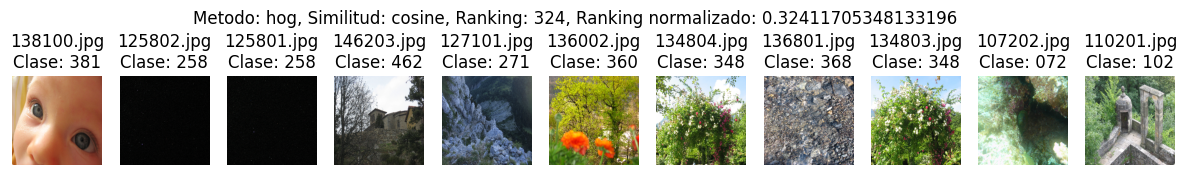

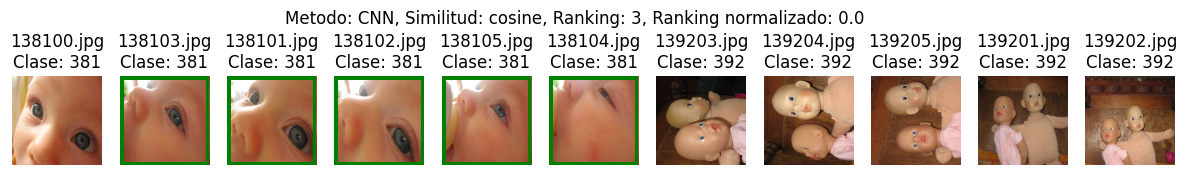

In [ ]:
mostrar_img("data/jpg/123400.jpg",data_hog,metod="hog",similitud="cosine")
mostrar_img("data/jpg/123400.jpg",data_cnn,metod="CNN",similitud="cosine")


### Ejemplo 3:

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 15608.19it/s]


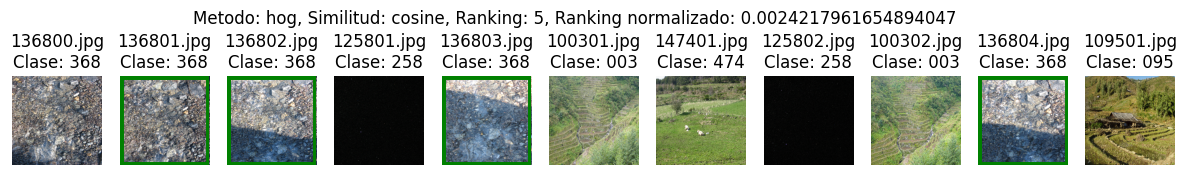

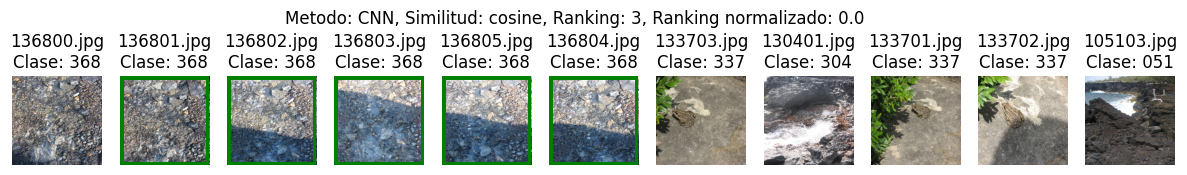

In [ ]:
mostrar_img("data/jpg/136800.jpg",data_hog,metod="hog",similitud="cosine")
mostrar_img("data/jpg/136800.jpg",data_cnn,metod="CNN",similitud="cosine")


## Ejemplo 4:

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 15128.77it/s]


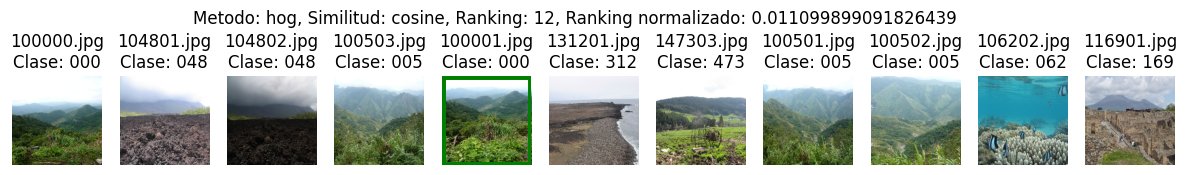

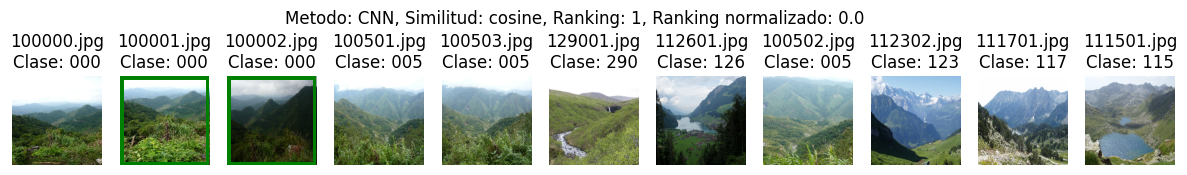

In [ ]:
mostrar_img("data/jpg/100000.jpg",data_hog,metod="hog",similitud="cosine")
mostrar_img("data/jpg/100000.jpg",data_cnn,metod="CNN",similitud="cosine")

## Ejemplo 5:

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 13113.07it/s]


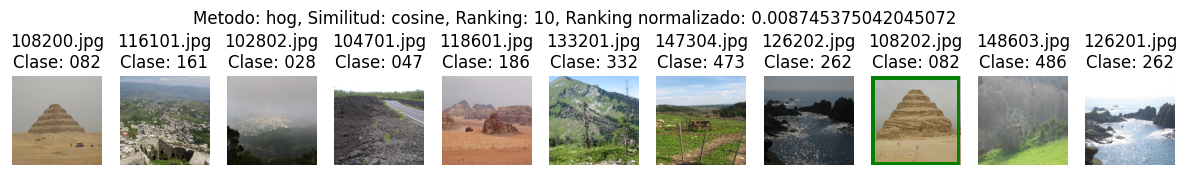

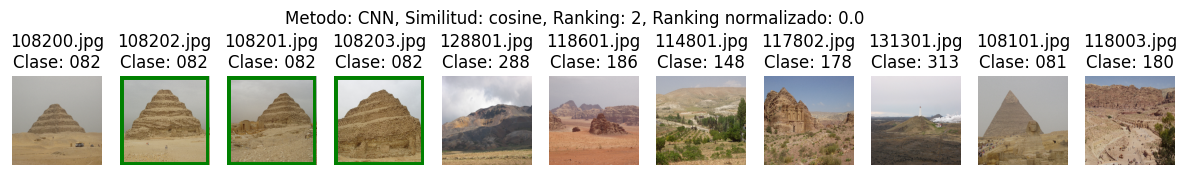

In [ ]:
mostrar_img("data/jpg/108200.jpg",data_hog,metod="hog",similitud="cosine")
mostrar_img("data/jpg/108200.jpg",data_cnn,metod="CNN",similitud="cosine")

## Optimizacion de tiempos de busqueda y reduccion de memoria:

Procederemos a usar Pca para reducir la dimensionalidad de los datos y asi poder reducir el tiempo de busqueda y la memoria utilizada.

Primero debemos de encontrar el numero de componentes principales que nos permitan reducir la dimensionalidad de los datos sin perder informacion.
Para ello haremos un grafico de la varianza acumulada por cada componente principal, para asi encontrar el punto en que la varianza acumulada sea mayor al 90% de la varianza total.

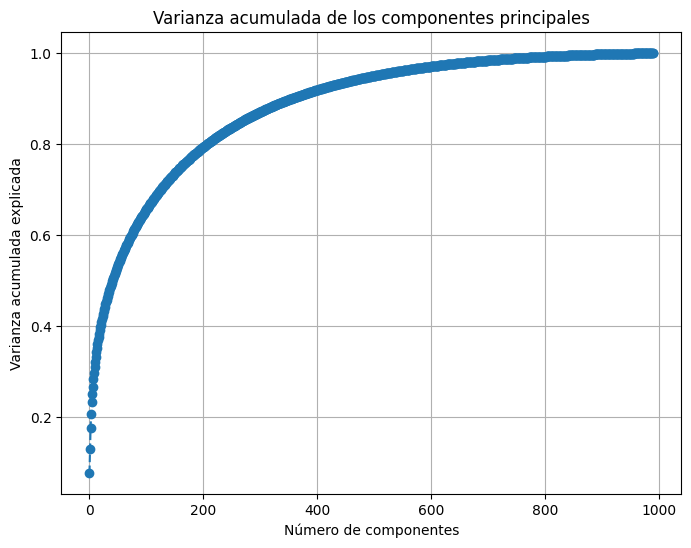

In [ ]:
from sklearn.decomposition import PCA

features_hog = data_hog["Features"].values.tolist()
data = features_hog
data_normalized = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
num_components = None
pca = PCA(n_components=num_components)
pca.fit(data_normalized)
data_pca = pca.transform(data_normalized)
variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(variance_ratio_cumsum, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada de los componentes principales')
plt.grid(True)
plt.show()


En este caso se puede ver que con 600 componentes principales se puede reducir la dimensionalidad de los datos sin perder informacion.

In [ ]:
pca_hog=PCA(n_components=600)
feature_hog_pca=pca_hog.fit_transform(features_hog)
data_hog_pca=data_hog.copy()
data_hog_pca["Features"]=feature_hog_pca.tolist()


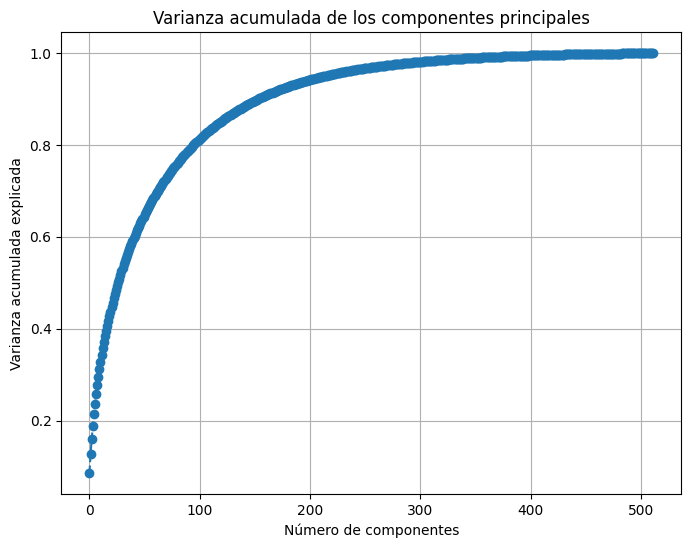

In [ ]:
features_cnn = data_cnn["Features"].values.tolist()
data = features_cnn
data_normalized = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
num_components = None
pca = PCA(n_components=num_components)
pca.fit(data_normalized)
data_pca = pca.transform(data_normalized)
variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(variance_ratio_cumsum, marker='o', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.title('Varianza acumulada de los componentes principales')
plt.grid(True)
plt.show()

Para cnn notamos que con 250 componentes principales se puede reducir la dimensionalidad de los datos sin perder informacion.

In [ ]:
pca_cnn=PCA(n_components=250)
feature_cnn_pca=pca_cnn.fit_transform(features_cnn)
data_cnn_pca=data_cnn.copy()
data_cnn_pca["Features"]=feature_cnn_pca.tolist()

In [ ]:
def ordenar_relevancia_pca(data:list, query:str,metod:str,similitud:str,pca,show_bar:bool=True)->list:
    """
    Funcion que ordena las imagenes de la base de datos por relevancia
    """
    data_copy=data.copy()
    features_query = pca.transform(feature_extractor(query, metod, model).reshape(1, -1)).ravel()
    if show_bar:
        data_copy["Distancias"] = [similarity_measure(x, features_query, similitud) for x in tqdm(data_copy["Features"], desc="Calculando distancias")]
    else:
        data_copy["Distancias"] = [similarity_measure(x, features_query, similitud) for x in data_copy["Features"]]
    data_copy=data_copy.sort_values(by=["Distancias"])
    data_copy.reset_index(drop=True, inplace=True)
    return data_copy
def mostrar_img_pca(path:str,data:pd.DataFrame,metod:str="hog",similitud:str="cosine",pca=None,show_img:bool=True):
    if not show_img:
        data2=ordenar_relevancia_pca(data,path,metod,similitud,pca,show_bar=False)
        ranking=rank(path,data2)
        ranking_normalizado=rank_normalizado(path,data2)
        return
    img=cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb=cv2.resize(img_rgb,(256,256))
    fig, axes = plt.subplots(1, 11, figsize=(15, 6))
    axes[0].imshow(img_rgb)
    axes[0].axis('off')
    axes[0].set_title(path.split("/")[-1]+"\n"+"Clase: "+path.split("/")[-1][1:4])

    data2=ordenar_relevancia_pca(data,path,metod,similitud,pca)
    ranking=rank(path,data2)
    ranking_normalizado=rank_normalizado(path,data2)
    fig.suptitle("Metodo: "+metod+", Similitud: "+similitud+", Ranking: "+str(ranking)+", Ranking normalizado: "+str(ranking_normalizado), y=0.68)

    for i in range(0, 10):
        img=cv2.imread("data/jpg/"+data2["Filename"][i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb=cv2.resize(img_rgb,(256,256))
        axes[i+1].imshow(img_rgb)
        axes[i+1].axis('off')
        axes[i+1].set_title(data2["Filename"][i]+"\n"+"Clase: "+data2["Filename"][i][1:4])
        if data2["Filename"][i][1:4] == path.split("/")[-1][1:4]:
            x_min, x_max = axes[i+1].get_xlim()
            y_min, y_max = axes[i+1].get_ylim()
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=5, edgecolor='g', facecolor='none')
            axes[i+1].add_patch(rect)

### Resultados totales usando PCA:

In [ ]:
def calcular_aciertos_con_ranking_cero_pca(data: pd.DataFrame, metod: str, similitud: str,pca):
    total_queries = 0
    aciertos = 0
    for filename in os.listdir("data/jpg"):
        if filename[-6:-4] == "00":
            filename = "data/jpg/" + filename
            data_sorted = ordenar_relevancia_pca(data, filename, metod, similitud,pca, show_bar=False)
            ranking_normalizado = rank_normalizado(filename, data_sorted)
            if ranking_normalizado == 0.0:
                aciertos += 1
            total_queries += 1
    return aciertos, total_queries
aciertos_hog_ranking_cero, total_queries_hog_ranking_cero = calcular_aciertos_con_ranking_cero_pca(data_hog_pca, "hog", "cosine",pca_hog)
aciertos_cnn_ranking_cero, total_queries_cnn_ranking_cero = calcular_aciertos_con_ranking_cero_pca(data_cnn_pca, "CNN", "cosine",pca_cnn)
porcentaje_aciertos_hog = (aciertos_hog_ranking_cero / total_queries_hog_ranking_cero) * 100
porcentaje_aciertos_cnn = (aciertos_cnn_ranking_cero / total_queries_cnn_ranking_cero) * 100
print(f"Aciertos usando HOG y PCA: {aciertos_hog_ranking_cero} de {total_queries_hog_ranking_cero} ({porcentaje_aciertos_hog:.2f}%)")
print(f"Aciertos usando CNN y PCA: {aciertos_cnn_ranking_cero} de {total_queries_cnn_ranking_cero} ({porcentaje_aciertos_cnn:.2f}%)")


Aciertos usando HOG y PCA: 88 de 500 (17.60%)
Aciertos usando CNN y PCA: 323 de 500 (64.60%)


## Recordemos que:
Aciertos usando HOG: 65 de 500 (13.00%)

Aciertos usando CNN: 322 de 500 (64.40%)

Por lo que usando PCA logramos que nuestro clasificador mejorara su rendimiento para ambos clasificadores


### Ejemplos usando PCA:

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 11647.22it/s]


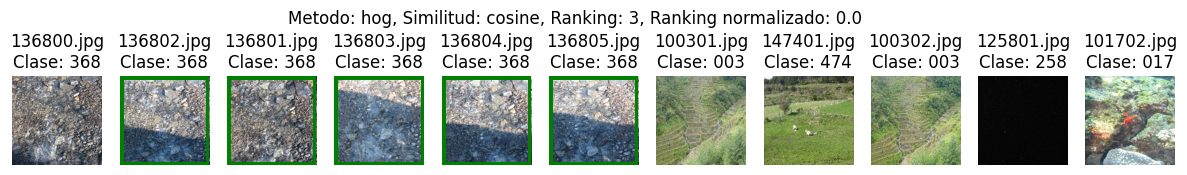

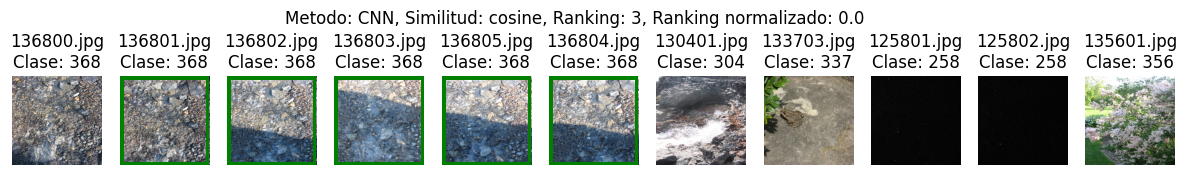

In [ ]:
mostrar_img_pca("data/jpg/123400.jpg",data_hog_pca,metod="hog",similitud="cosine",pca=pca_hog)
mostrar_img_pca("data/jpg/123400.jpg",data_cnn_pca,metod="CNN",similitud="cosine",pca=pca_cnn)

Calculando distancias: 100%|██████████| 991/991 [00:00<00:00, 12376.41it/s]


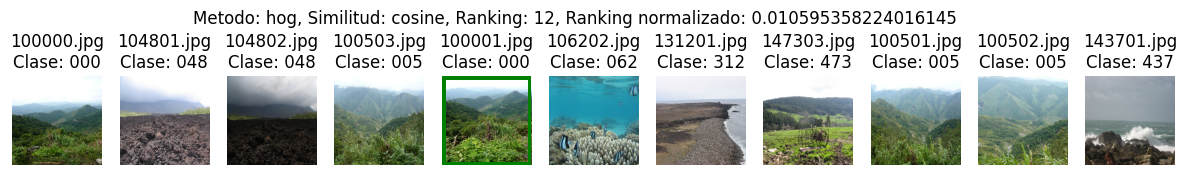

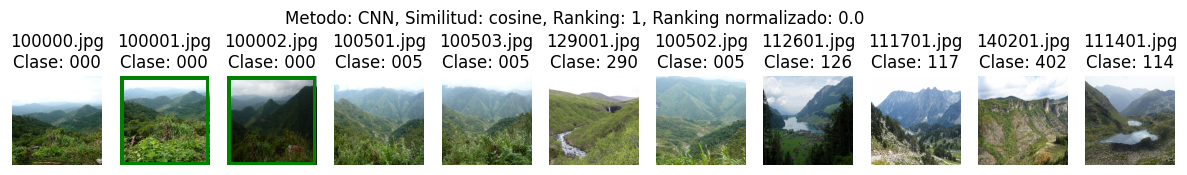

In [ ]:
mostrar_img_pca("data/jpg/100000.jpg",data_hog_pca,metod="hog",similitud="cosine",pca=pca_hog)
mostrar_img_pca("data/jpg/100000.jpg",data_cnn_pca,metod="CNN",similitud="cosine",pca=pca_cnn)

In [ ]:
import sys
tamaño_hog = sys.getsizeof(data_hog)
tamaño_cnn = sys.getsizeof(data_cnn)
tamaño_hog_pca = sys.getsizeof(data_hog_pca)
tamaño_cnn_pca = sys.getsizeof(data_cnn_pca)
print(f"Tamaño de la base de datos HOG: {tamaño_hog} bytes")
print(f"Tamaño de la base de datos CNN: {tamaño_cnn} bytes")
reduccion_hog = (1 - (tamaño_hog_pca / tamaño_hog)) * 100
reduccion_cnn = (1 - (tamaño_cnn_pca / tamaño_cnn)) * 100
print(f"Reducción de tamaño para HOG con PCA: {reduccion_hog:.2f}%")
print(f"Reducción de tamaño para CNN con PCA: {reduccion_cnn:.2f}%")


Tamaño de la base de datos HOG: 128619061 bytes
Tamaño de la base de datos CNN: 2215029 bytes
Reducción de tamaño para HOG con PCA: 96.21%
Reducción de tamaño para CNN con PCA: 5.37%


In [ ]:
import time
start_time = time.time()
for _ in range(3):
    mostrar_img("data/jpg/136800.jpg", data_hog, metod="hog", similitud="cosine", show_img=False)
end_time = time.time()
avg_time_without_pca_hog = (end_time - start_time) / 3
start_time = time.time()
for _ in range(3):
    mostrar_img_pca("data/jpg/136800.jpg", data_hog_pca, metod="hog", similitud="cosine", pca=pca_hog, show_img=False)
end_time = time.time()
avg_time_with_pca_hog = (end_time - start_time) / 3
decrease_percentage_hog = ((avg_time_without_pca_hog - avg_time_with_pca_hog) / avg_time_without_pca_hog) * 100
print("Tiempo de ejecucion para HOG sin PCA:", avg_time_without_pca_hog,"segundos")
print("Tiempo de ejecucion para HOG con PCA:", avg_time_with_pca_hog,"segundos")
print(f"Porcentaje de disminucion con PCA para HOG: {decrease_percentage_hog:.2f}%")


Tiempo de ejecucion para HOG sin PCA: 0.54456893603007 segundos
Tiempo de ejecucion para HOG con PCA: 0.3867432276407878 segundos
Porcentaje de disminucion con PCA para HOG: 28.98%


In [ ]:
start_time = time.time()
for _ in range(3):
    mostrar_img("data/jpg/136800.jpg", data_cnn, metod="CNN", similitud="cosine", show_img=False)
end_time = time.time()
avg_time_without_pca_cnn = (end_time - start_time) / 3
start_time = time.time()
for _ in range(3):
    mostrar_img_pca("data/jpg/136800.jpg", data_cnn_pca, metod="CNN", similitud="cosine", pca=pca_cnn, show_img=False)
end_time = time.time()
avg_time_with_pca_cnn = (end_time - start_time) / 3
decrease_percentage = ((avg_time_without_pca_cnn - avg_time_with_pca_cnn) / avg_time_without_pca_cnn) * 100
print("Tiempo de ejecucion para CNN sin PCA:", avg_time_without_pca_cnn,"segundos")
print("Tiempo de ejecucion para CNN con PCA:", avg_time_with_pca_cnn,"segundos")
print(f"Porcentaje de disminucion con PCA: {decrease_percentage:.2f}%")


Tiempo de ejecucion para CNN sin PCA: 0.36211228370666504 segundos
Tiempo de ejecucion para CNN con PCA: 0.28245242436726886 segundos
Porcentaje de disminucion con PCA: 22.00%
